In [1]:
import sys
sys.path.append('src')
from src.trainer import EuroSATTrainer
from src.load_data import get_eurosat_dataloaders

import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask
import zipfile
import rasterio
import json
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import torch
from collections import Counter

# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load model which standardizes input impages
best_model_path = 'bin/epoch=23-step=6767.ckpt'
model = EuroSATTrainer.load_from_checkpoint(best_model_path)

if torch.cuda.is_available():
    model.to('cuda:0');
    print("Model sent to cuda.")



Model sent to cuda.


In [6]:
# load rasters (downloaded through Sentinel Data Download Walkthrough.ipynb)
earliest_raster = rio.open('data/S2A_MSIL2A_20220226T154221_N0400_R011_T18TWL_20220226T204651.tiff').read()
middle_raster = rio.open('data/S2A_MSIL2A_20220510T154821_N0400_R054_T18TWL_20220510T230512.tiff').read()
latest_raster = rio.open('data/S2A_MSIL2A_20220825T155151_N0400_R011_T18TWL_20220825T220800.tiff').read()

In [7]:
# tiled image setup. Can only feed into model 3x64x64 inputs.
tile = 64
img_height = latest_raster.shape[1]
img_width = latest_raster.shape[2]

num_vertical_tiles = img_height // tile
num_horizontal_tiles = img_width // tile

cropped_latest_img = latest_raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]
cropped_earliest_img = earliest_raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]


In [8]:
# grab label dictionary
_, _, label_dict = get_eurosat_dataloaders(batch_size = 1, limit=1, test_size = .1)

100%|██████████| 1/1 [00:00<00:00, 5461.33it/s]


In [9]:


def get_tiled_predictions(cropped_img):

    tiled_array = np.zeros((cropped_img.shape[1],cropped_img.shape[2]))
    model.eval();
    tile_predictions = []
    tiled_images = []
    with torch.no_grad():
        for i in tqdm(range(0, img_height-tile, tile)):
            for j in range(0, img_width-tile, tile):
                tiled_image = cropped_img[:,i:i+tile,j:j+tile]        
                if tiled_image.std() == 0:
                    tiled_array[i:i+tile,j:j+tile] = -1
                else:
                    x = torch.tensor(tiled_image.astype(np.int16))
                    x = (x - x.min()) / (x.max() - x.min())   
                    y_pred = model.forward(x.unsqueeze(0).cuda())
                    predicted_class = y_pred.argmax().cpu().item()
                    tiled_array[i:i+tile,j:j+tile] = predicted_class
                    tile_predictions.append(predicted_class)
                    tiled_images.append(tiled_image)

    return tile_predictions, tiled_array, tiled_images

In [10]:
%%time 
# run inference on a sliding window for all tiles of both images.
latest_tile_predictions, latest_tiled_array, latest_tiled_images = get_tiled_predictions(cropped_latest_img)
earliest_tile_predictions, earliest_tiled_array, earliest_tiled_images = get_tiled_predictions(cropped_earliest_img)


  0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /media/nvidia/NVME/pytorch/pytorch-v1.9.0/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 35/35 [00:33<00:00,  1.03it/s]

CPU times: user 32.7 s, sys: 13.7 s, total: 46.4 s
Wall time: 3min 31s


Text(0.5, 0.98, '2022-08-25')

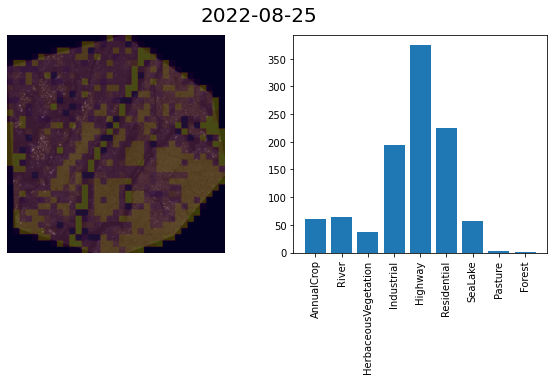

In [97]:
# view distribution of land mass classes for later tile
tile_counter = Counter(latest_tile_predictions)
latest_landmass_counts = {}
for key in tile_counter.keys():
    landmass = label_dict[key].replace('/','')
    latest_landmass_counts[landmass] = tile_counter[key]
    
plt.figure(figsize=(10,4))    

names = list(latest_landmass_counts.keys())
values = list(latest_landmass_counts.values())
plt.subplot(122)
plt.bar(range(len(latest_landmass_counts)), values, tick_label=names)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.subplot(121)
plt.imshow(cropped_latest_img.mean(axis=0),cmap='gray')
plt.imshow(latest_tiled_array,alpha=.25,cmap='plasma')
plt.axis('off')
plt.suptitle("2022-08-25",fontsize=20)



Text(0.5, 0.98, '2022-05-05')

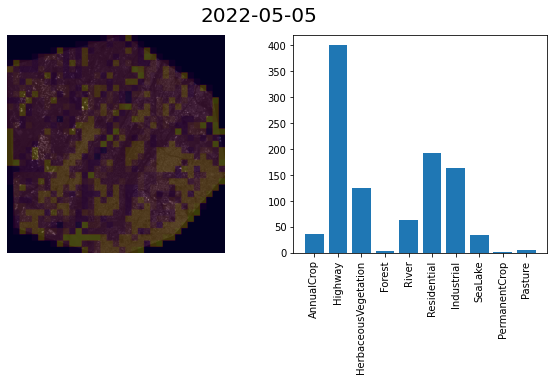

In [96]:
# view distribution of landmass types for earlier tile
tile_counter = Counter(earliest_tile_predictions)
earliest_landmass_counts = {}
for key in tile_counter.keys():
    landmass = label_dict[key].replace('/','')
    earliest_landmass_counts[landmass] = tile_counter[key]

plt.figure(figsize=(10,4))    
names = list(earliest_landmass_counts.keys())
values = list(earliest_landmass_counts.values())
plt.subplot(122)
plt.bar(range(len(earliest_landmass_counts)), values, tick_label=names)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.subplot(121)
plt.imshow(cropped_earliest_img.mean(axis=0),cmap='gray')
plt.imshow(earliest_tiled_array,alpha=.25,cmap='plasma')
plt.axis('off')
plt.suptitle("2022-05-05",fontsize=20)



# get percent change of each

In [82]:
pct_change_landmass = {}
for key in earliest_landmass_counts:
    if key not in latest_landmass_counts:
        pct_change_landmass[key] = 0
    else:
        pct_change_landmass[key] = (latest_landmass_counts[key] - earliest_landmass_counts[key]) / earliest_landmass_counts[key]

Text(0, 0.5, '% Change')

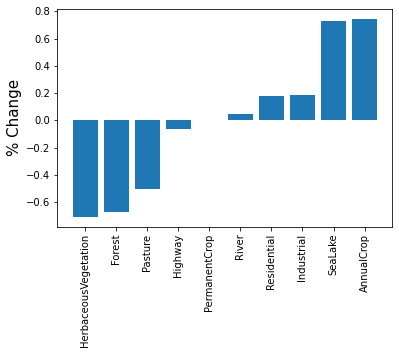

In [88]:
pct_change_landmass = dict(sorted(pct_change_landmass.items(), key=lambda item: item[1]))

names = list(pct_change_landmass.keys())
values = list(pct_change_landmass.values())

plt.bar(range(len(pct_change_landmass)), values, tick_label=names)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel("% Change",fontsize=15)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

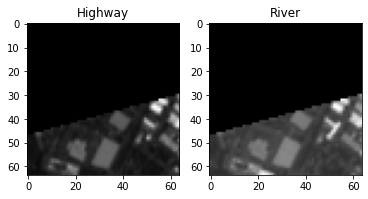

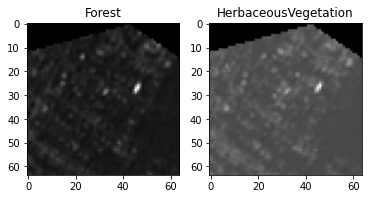

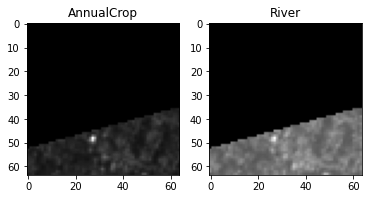

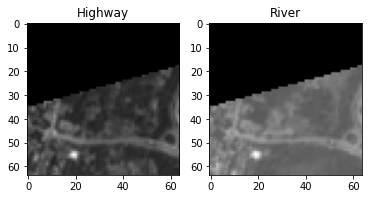

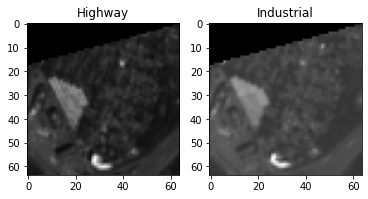

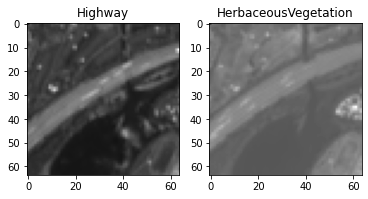

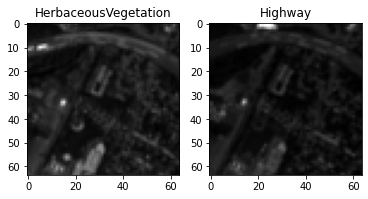

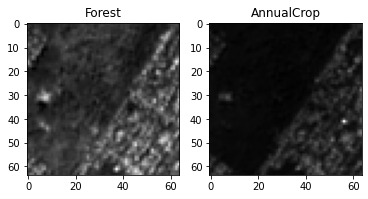

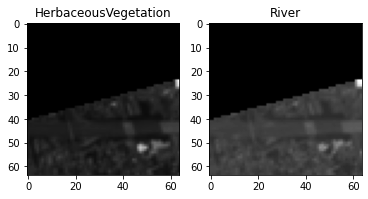

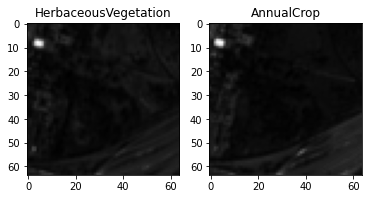

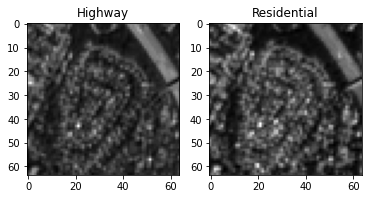

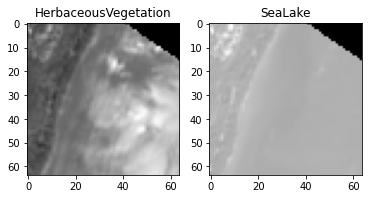

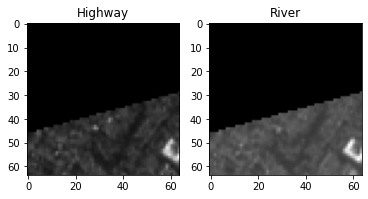

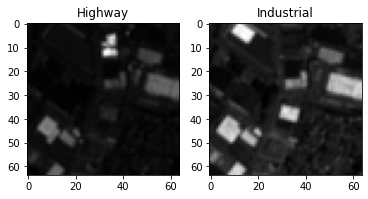

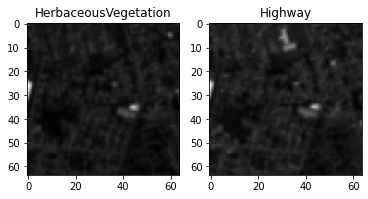

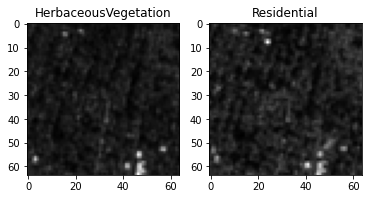

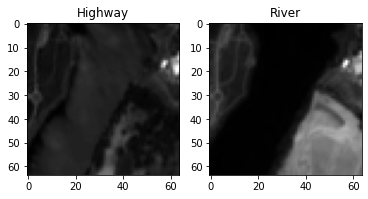

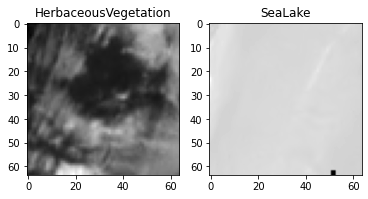

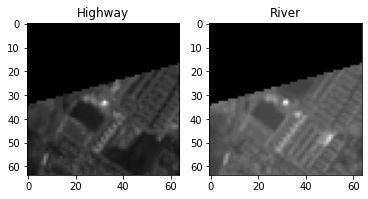

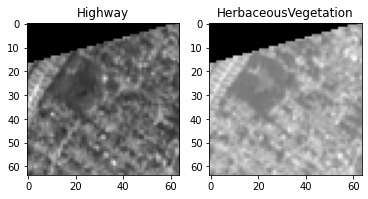

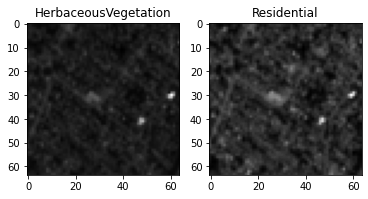

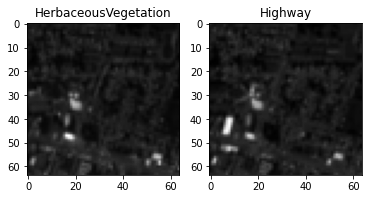

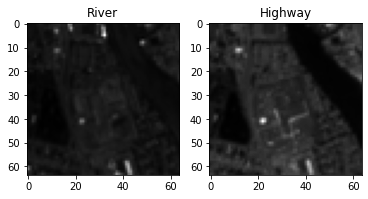

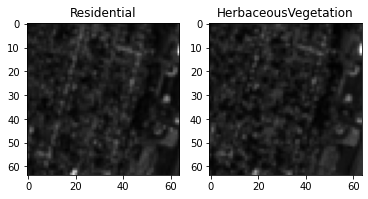

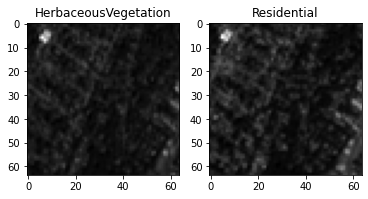

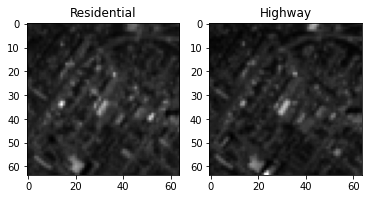

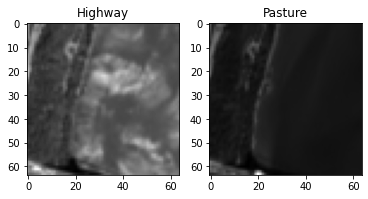

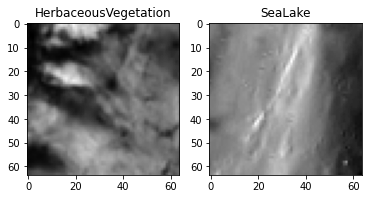

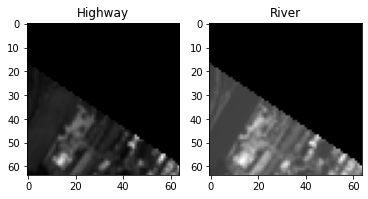

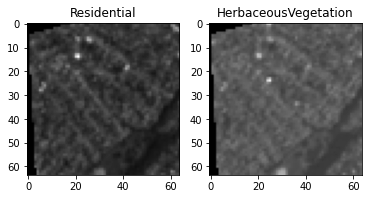

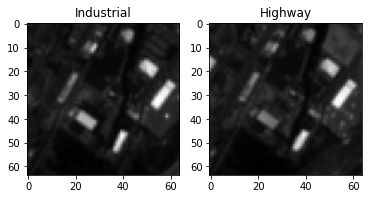

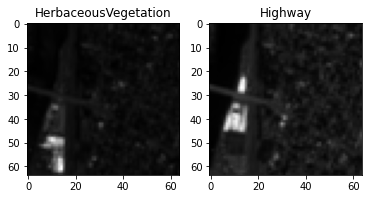

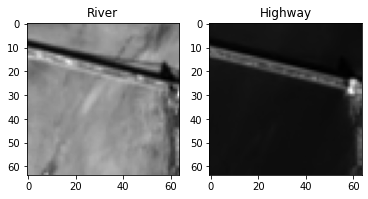

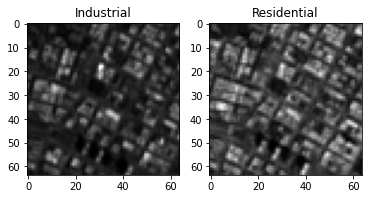

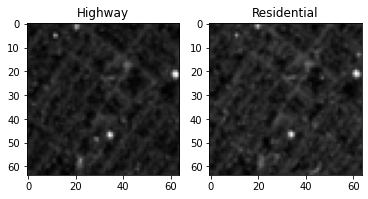

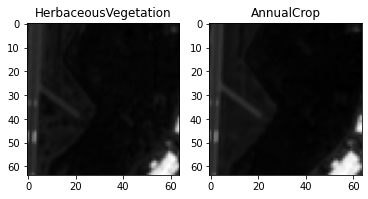

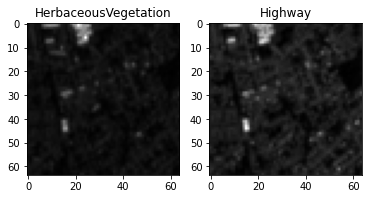

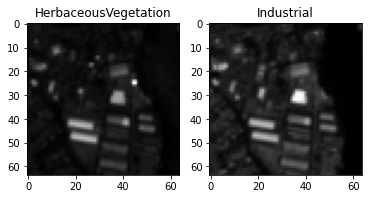

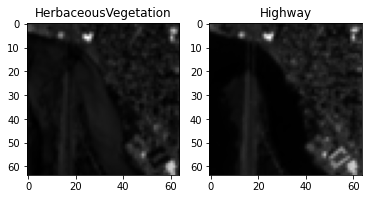

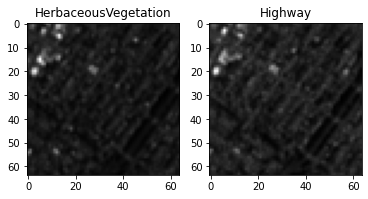

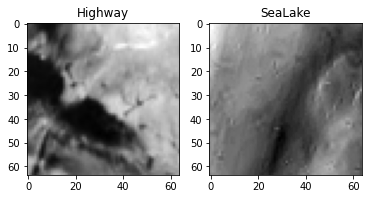

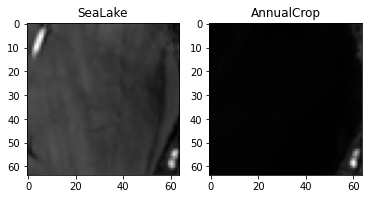

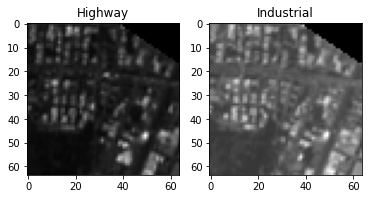

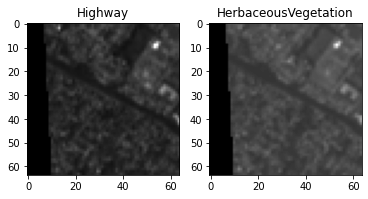

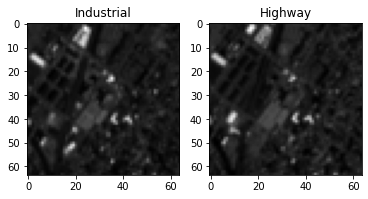

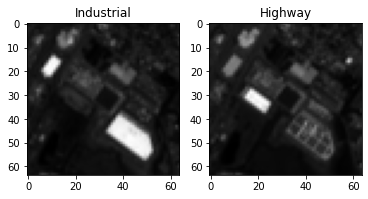

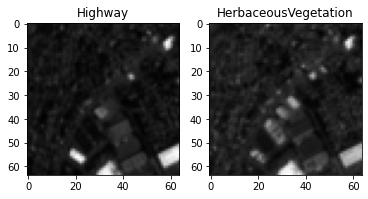

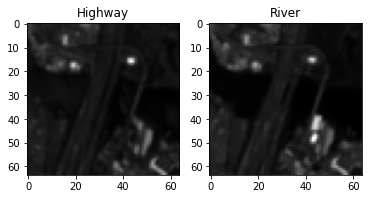

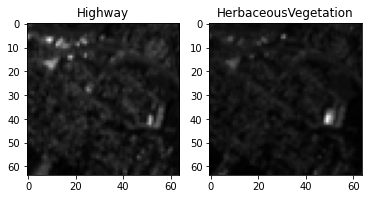

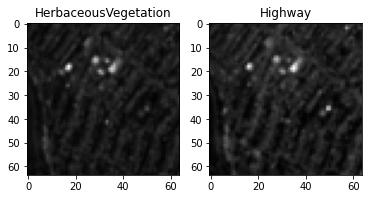

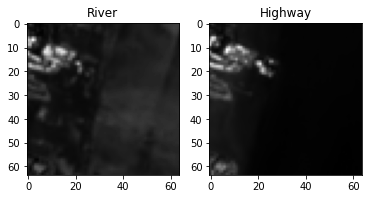

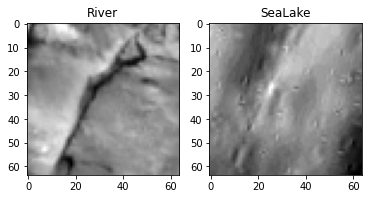

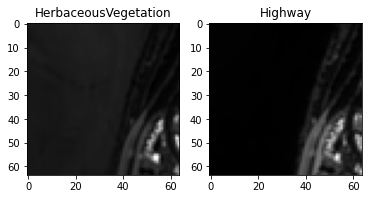

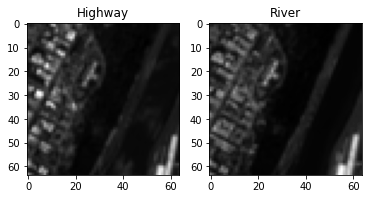

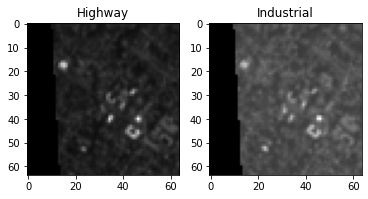

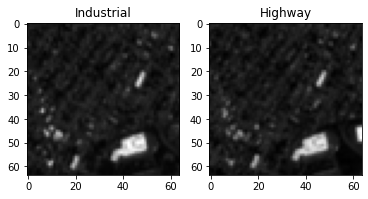

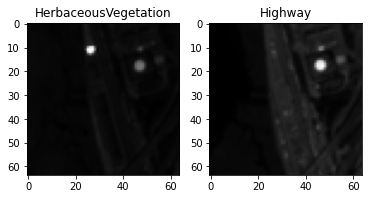

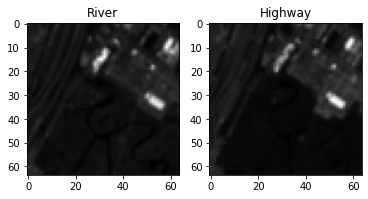

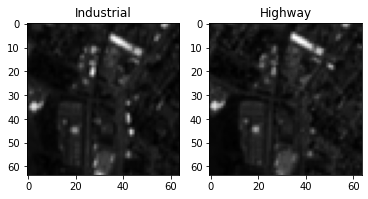

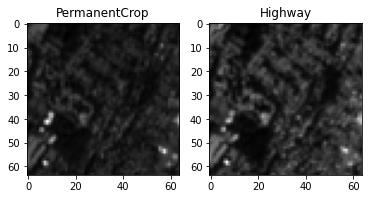

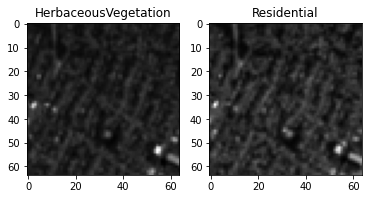

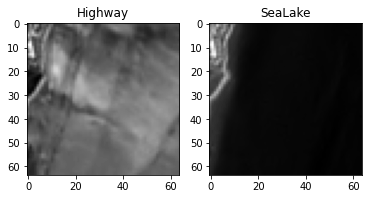

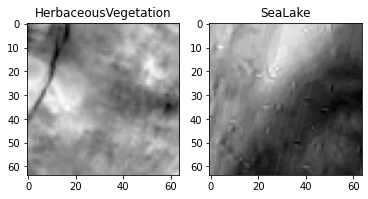

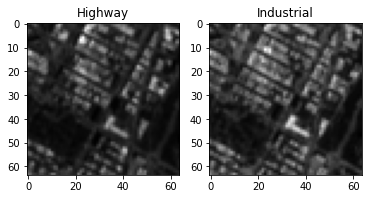

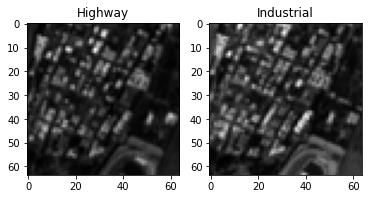

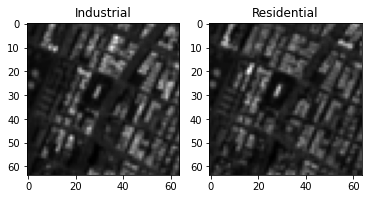

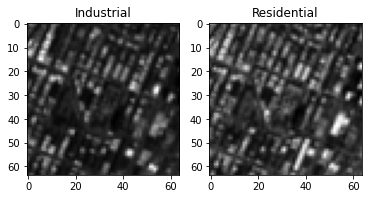

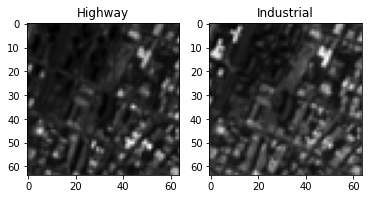

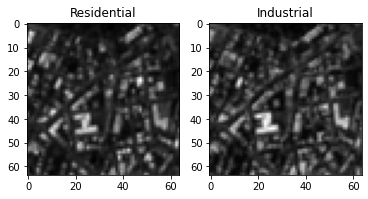

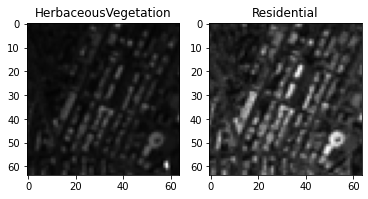

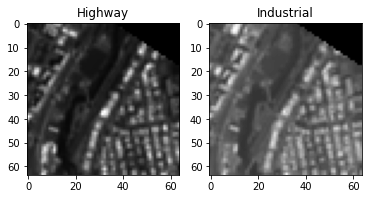

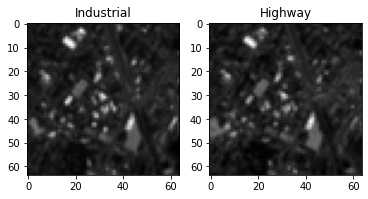

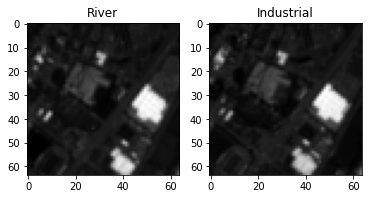

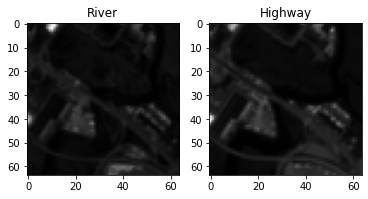

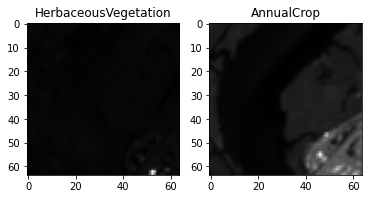

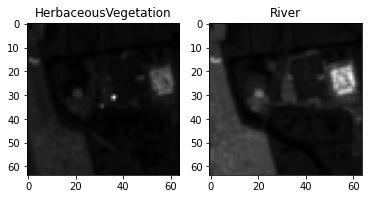

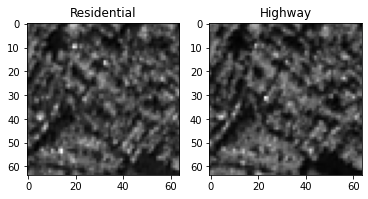

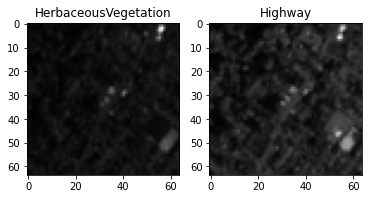

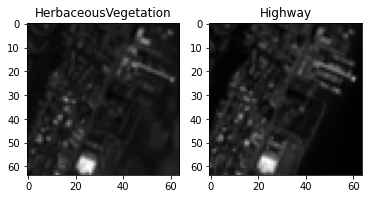

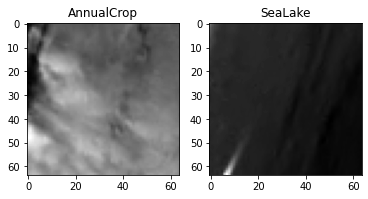

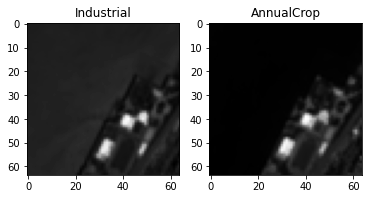

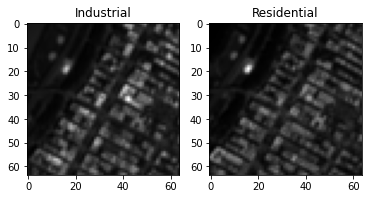

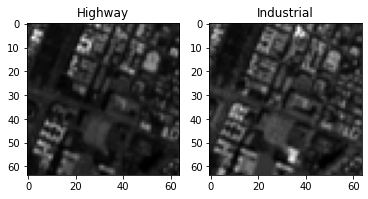

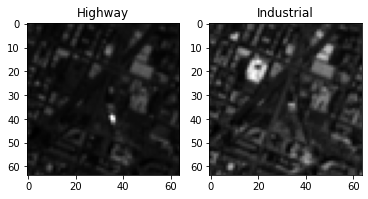

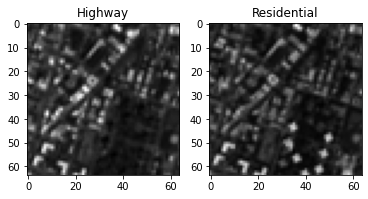

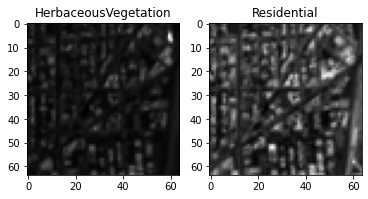

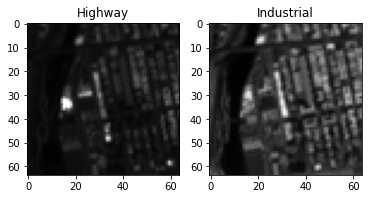

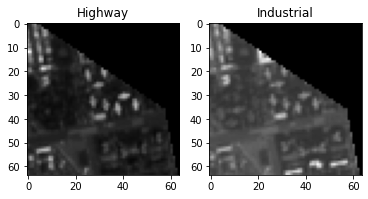

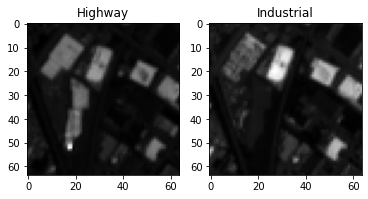

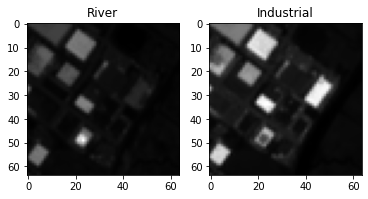

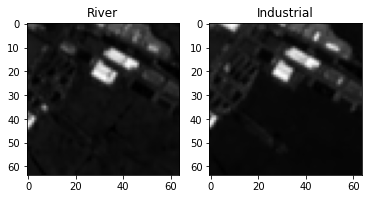

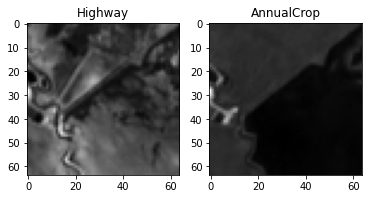

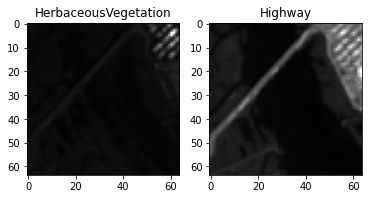

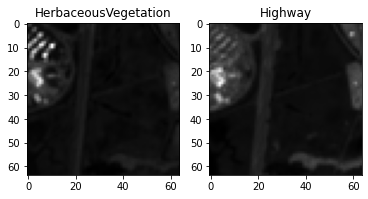

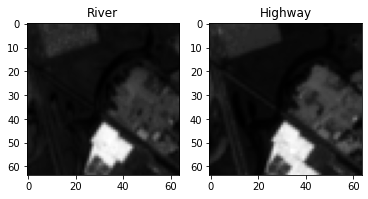

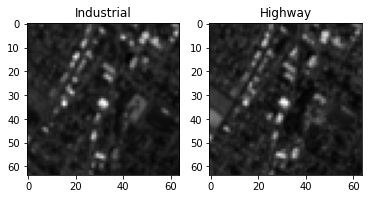

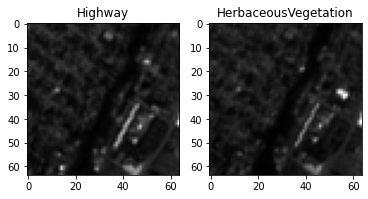

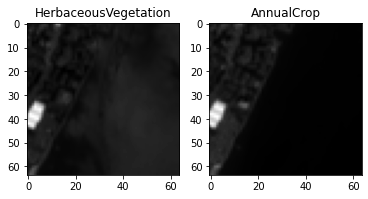

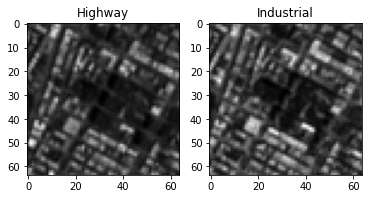

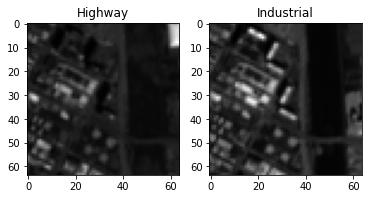

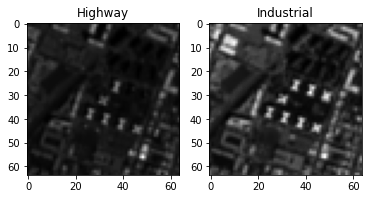

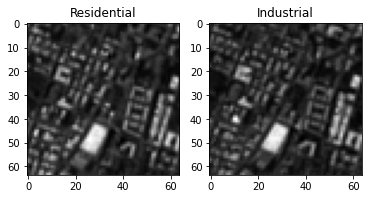

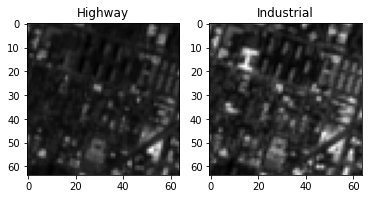

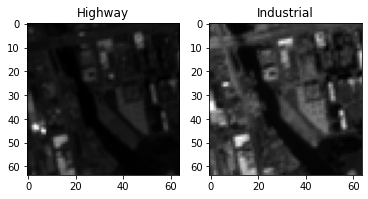

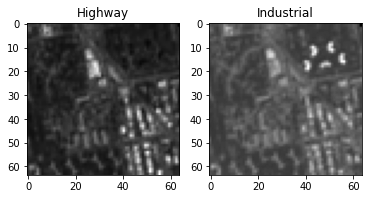

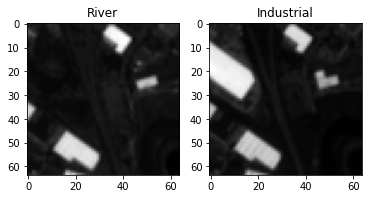

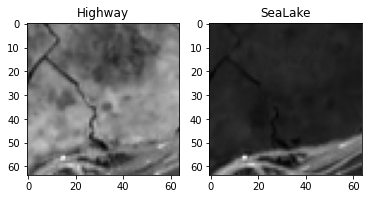

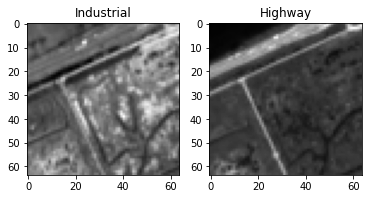

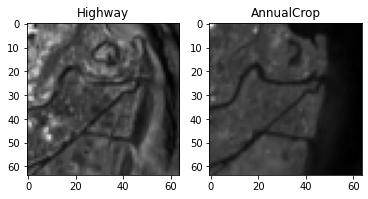

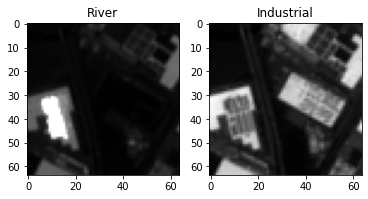

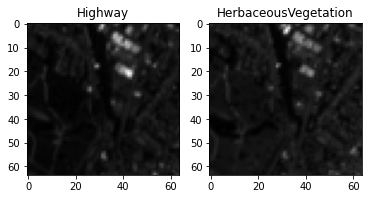

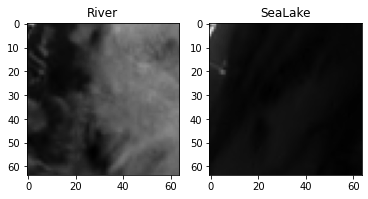

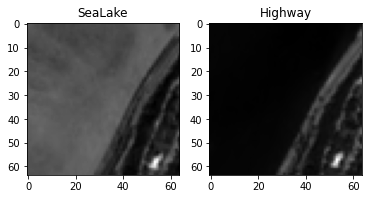

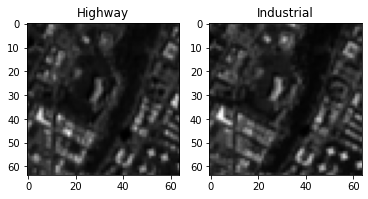

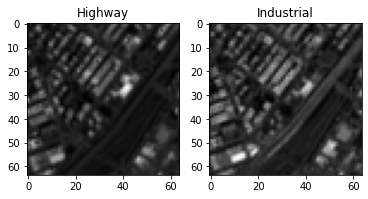

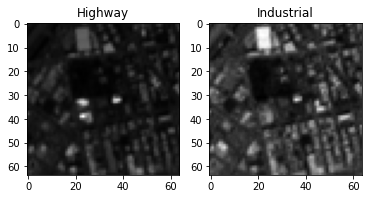

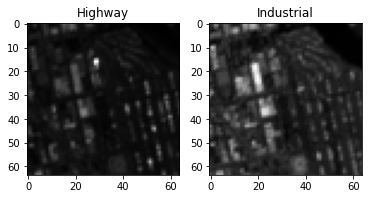

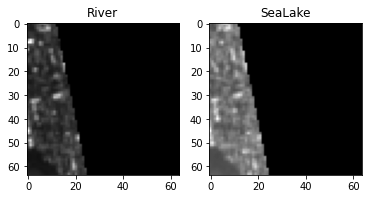

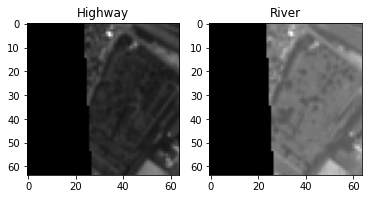

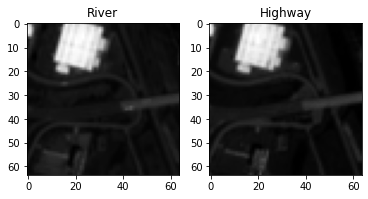

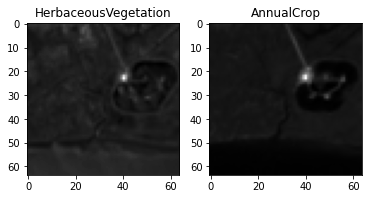

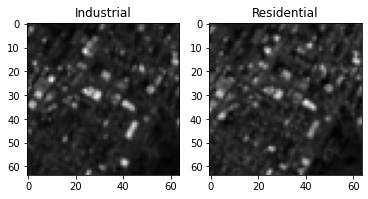

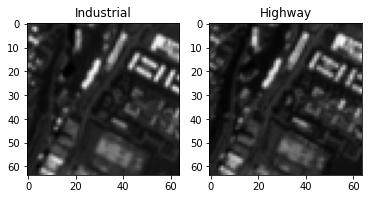

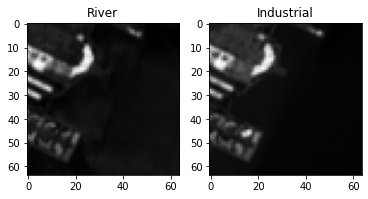

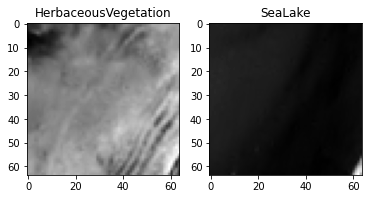

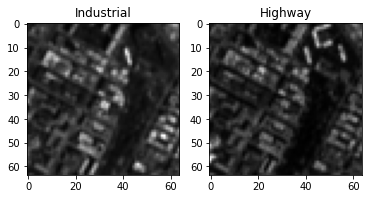

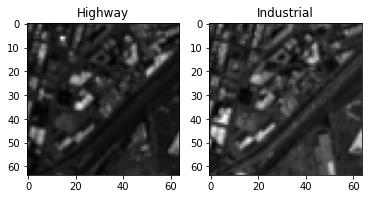

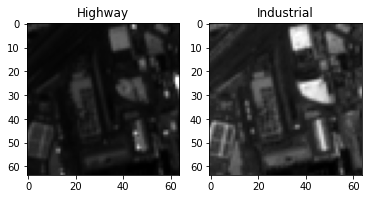

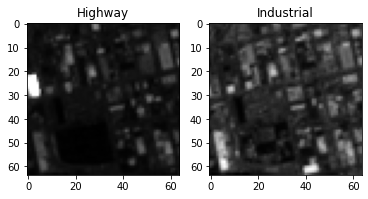

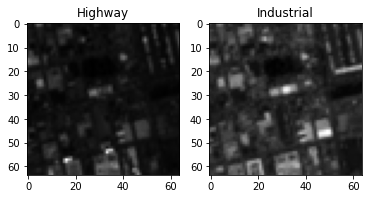

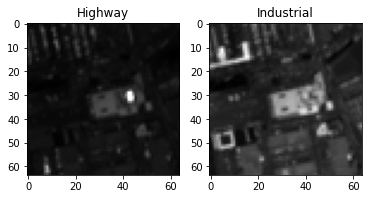

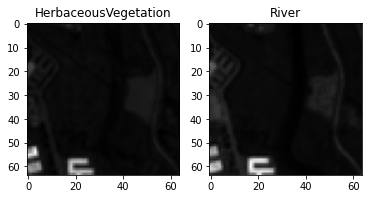

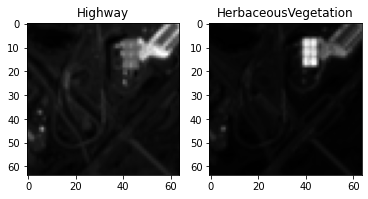

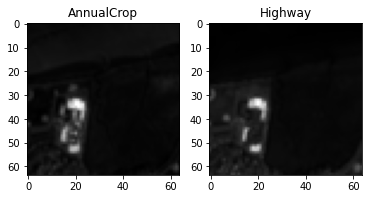

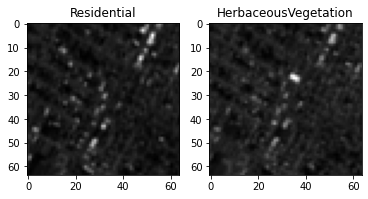

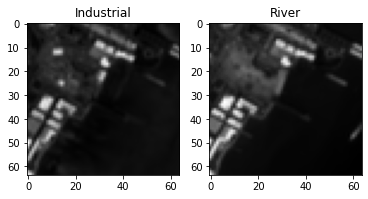

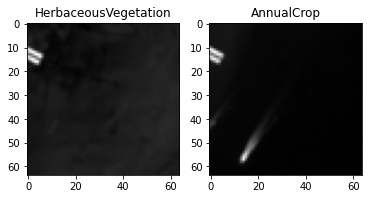

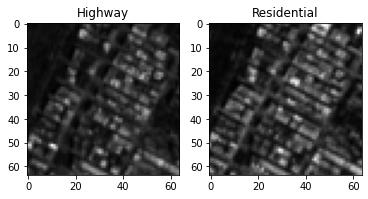

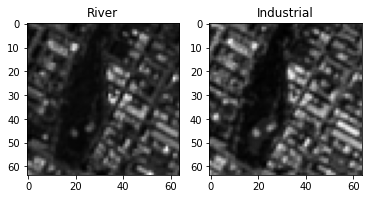

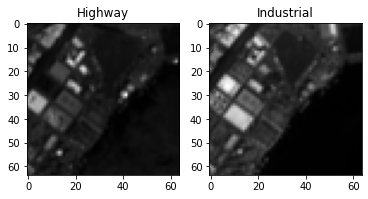

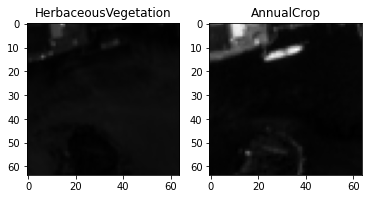

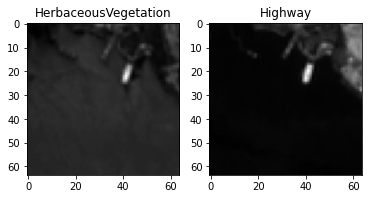

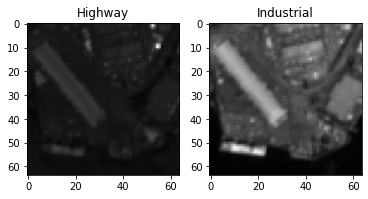

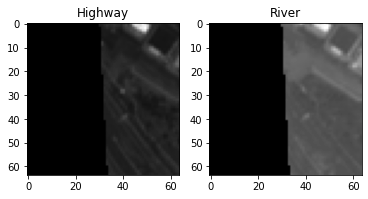

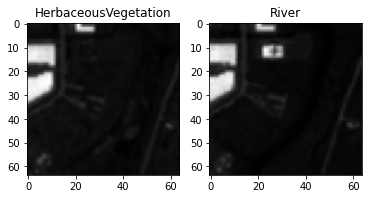

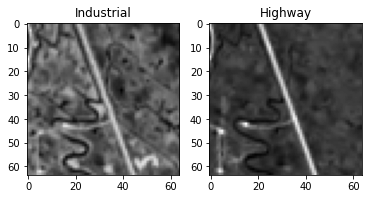

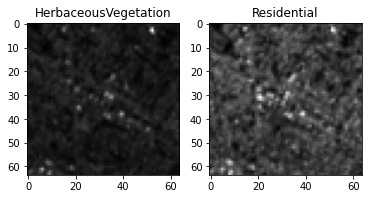

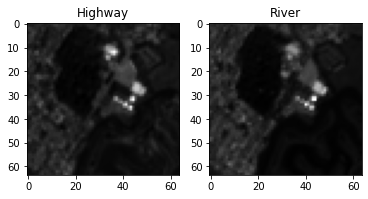

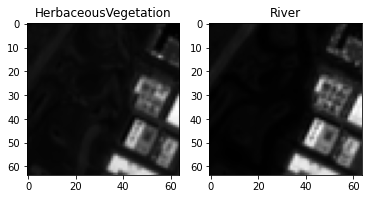

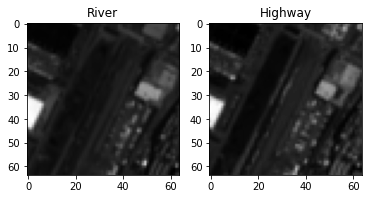

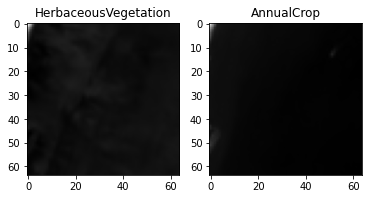

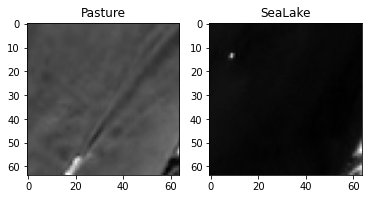

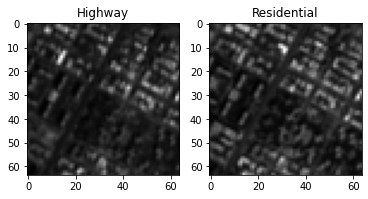

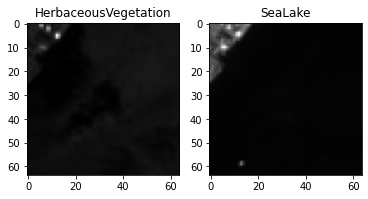

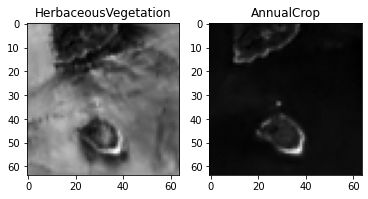

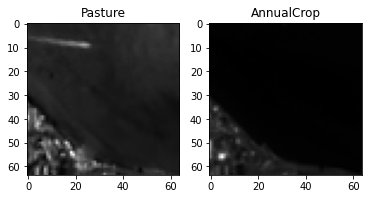

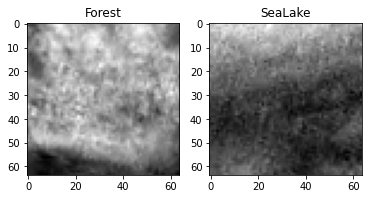

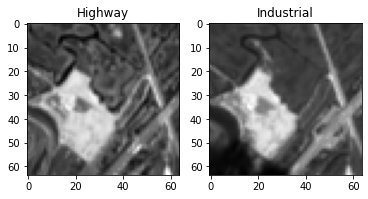

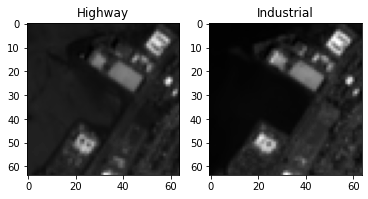

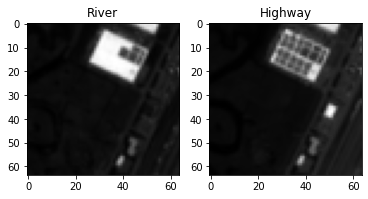

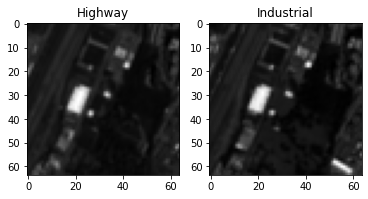

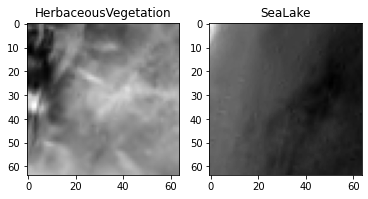

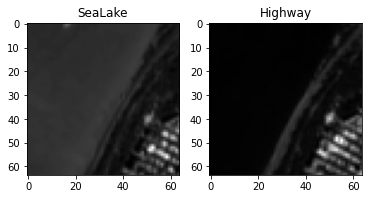

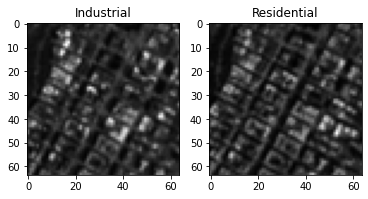

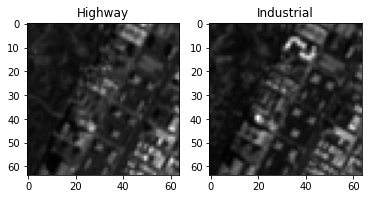

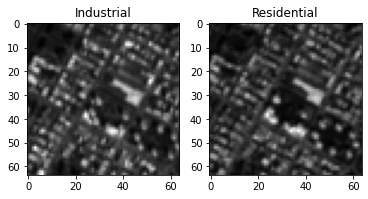

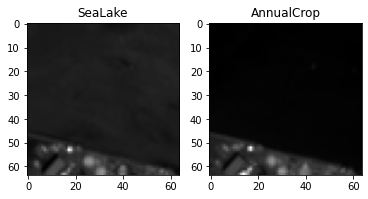

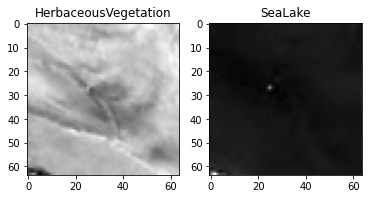

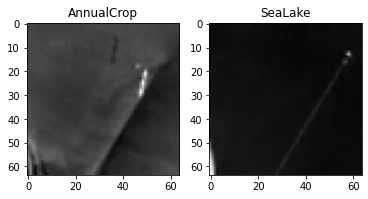

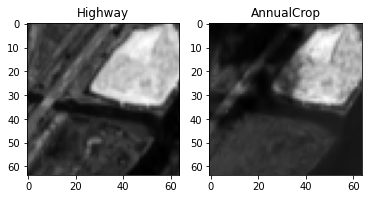

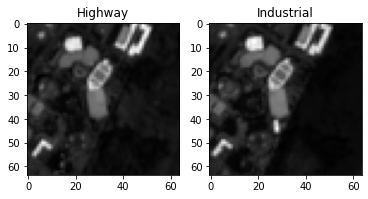

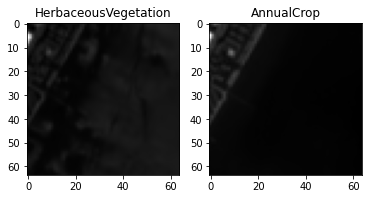

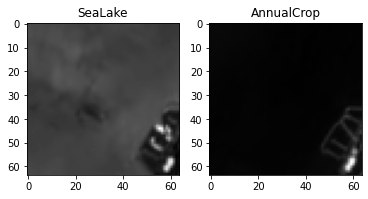

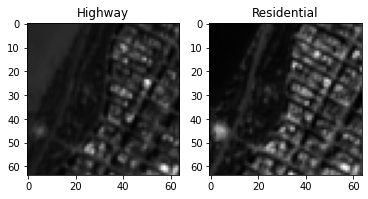

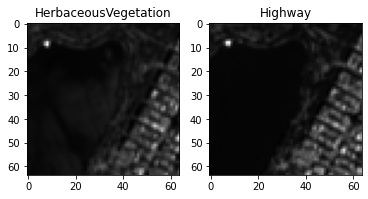

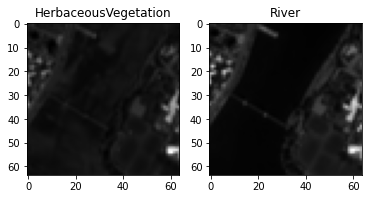

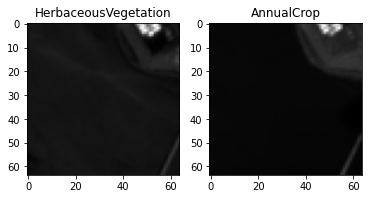

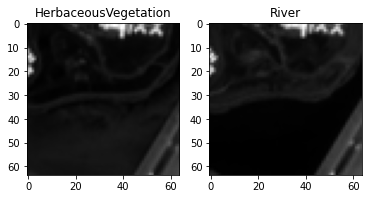

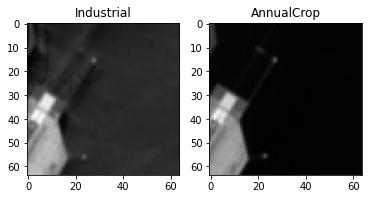

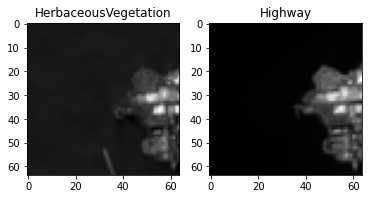

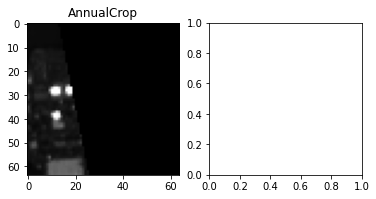

In [33]:
# view plots of all changed landmass predictions
for i, (earliest_pred, latest_pred) in enumerate(zip(earliest_tile_predictions,latest_tile_predictions)):
    if earliest_pred != latest_pred:
        plt.figure(figsize = (6,3))
        plt.subplot(121)
        plt.imshow(earliest_tiled_images[i].mean(axis=0),cmap='gray')
        plt.title(label_dict[earliest_pred].replace('/',''))
        plt.subplot(122)
        plt.imshow(latest_tiled_images[i].mean(axis=0),cmap='gray')
        plt.title(label_dict[latest_pred].replace('/',''))


In [34]:
tile_prediction_pairs = []
for i, (earliest_pred, latest_pred) in enumerate(zip(earliest_tile_predictions,latest_tile_predictions)):
    tile_prediction_pairs.append((earliest_pred,latest_pred))

In [39]:
label_dict

{0: '/AnnualCrop',
 1: '/Forest',
 2: '/HerbaceousVegetation',
 3: '/Highway',
 4: '/Industrial',
 5: '/Pasture',
 6: '/PermanentCrop',
 7: '/Residential',
 8: '/River',
 9: '/SeaLake'}

In [37]:
# view what the most common tile prediction changes were.
Counter(tile_prediction_pairs).most_common()

[((3, 3), 285),
 ((7, 7), 178),
 ((4, 4), 113),
 ((3, 4), 60),
 ((2, 3), 34),
 ((8, 8), 33),
 ((4, 3), 30),
 ((0, 0), 26),
 ((2, 2), 22),
 ((9, 9), 21),
 ((2, 9), 19),
 ((3, 8), 18),
 ((2, 0), 18),
 ((4, 7), 16),
 ((3, 7), 15),
 ((2, 7), 15),
 ((8, 3), 13),
 ((8, 4), 11),
 ((2, 8), 10),
 ((3, 2), 8),
 ((9, 0), 7),
 ((7, 3), 6),
 ((2, 4), 6),
 ((3, 9), 6),
 ((0, 9), 5),
 ((3, 0), 5),
 ((7, 2), 4),
 ((8, 9), 4),
 ((0, 8), 3),
 ((7, 4), 3),
 ((9, 3), 3),
 ((4, 0), 2),
 ((5, 0), 2),
 ((1, 2), 1),
 ((1, 0), 1),
 ((3, 5), 1),
 ((6, 3), 1),
 ((0, 3), 1),
 ((4, 8), 1),
 ((5, 9), 1),
 ((1, 9), 1),
 ((3, 1), 1),
 ((8, 7), 1),
 ((4, 2), 1),
 ((2, 5), 1),
 ((9, 4), 1),
 ((5, 3), 1),
 ((9, 2), 1)]

100%|██████████| 1016/1016 [00:04<00:00, 218.18it/s]


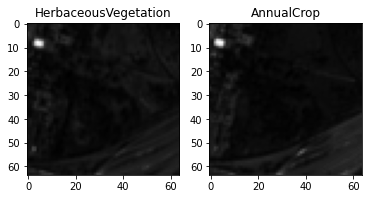

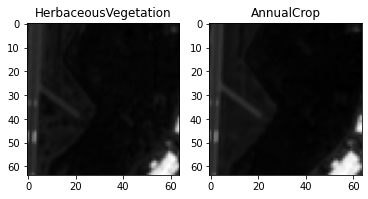

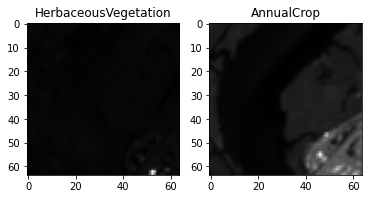

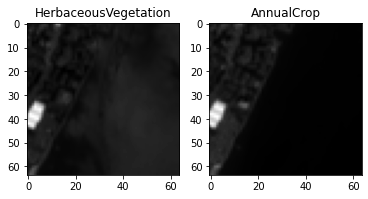

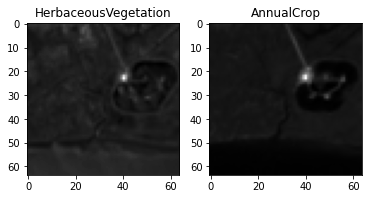

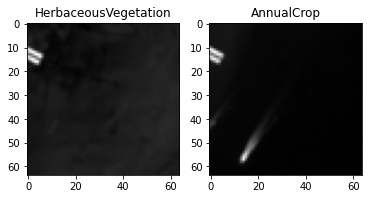

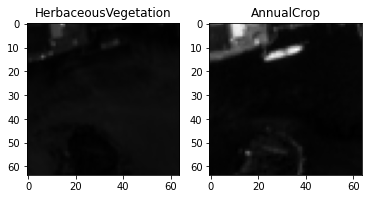

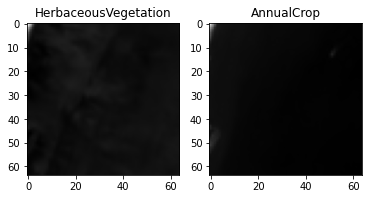

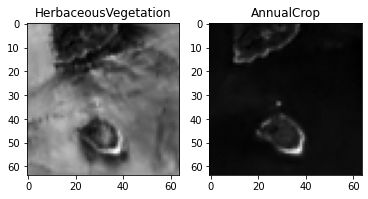

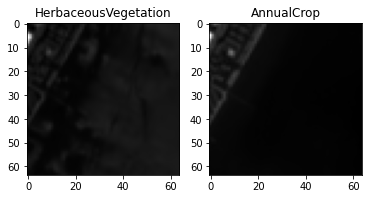

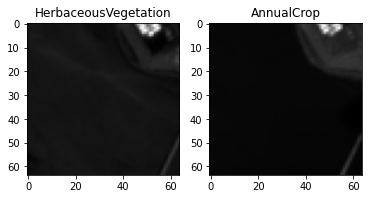

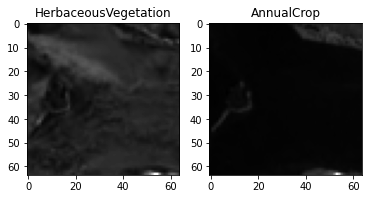

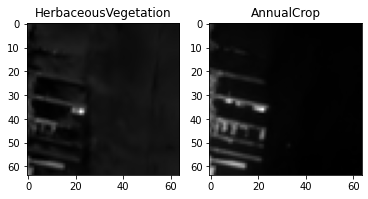

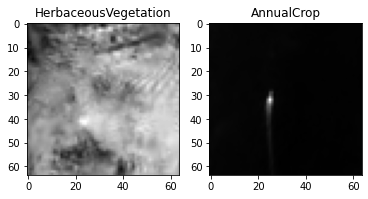

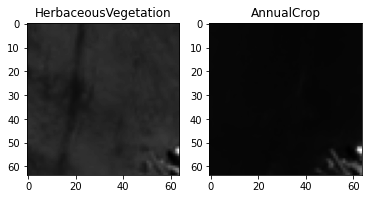

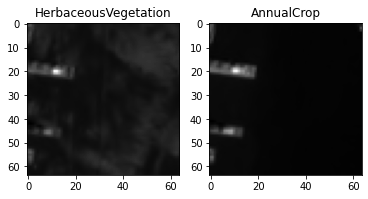

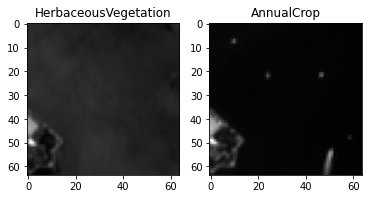

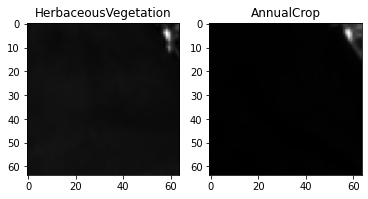

In [93]:

for i in tqdm(range(len(tile_prediction_pairs))):
    if tile_prediction_pairs[i] == (2,0):

        
        earliest_pred = earliest_tile_predictions[i]
        latest_pred = latest_tile_predictions[i]
        plt.figure(figsize = (6,3))
        plt.subplot(121)
        plt.imshow(earliest_tiled_images[i].mean(axis=0),cmap='gray')
        plt.title(label_dict[earliest_pred].replace('/',''))
        plt.subplot(122)
        plt.imshow(latest_tiled_images[i].mean(axis=0),cmap='gray')
        plt.title(label_dict[latest_pred].replace('/',''))


Text(0.5, 1.0, 'Highway')

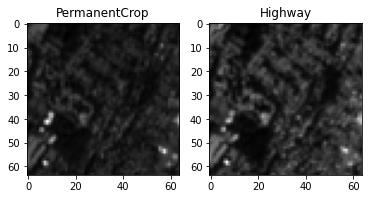

In [98]:
i = tile_prediction_pairs.index((6,3))

earliest_pred = earliest_tile_predictions[i]
latest_pred = latest_tile_predictions[i]
plt.figure(figsize = (6,3))
plt.subplot(121)
plt.imshow(earliest_tiled_images[i].mean(axis=0),cmap='gray')
plt.title(label_dict[earliest_pred].replace('/',''))
plt.subplot(122)
plt.imshow(latest_tiled_images[i].mean(axis=0),cmap='gray')
plt.title(label_dict[latest_pred].replace('/',''))
